In [1]:
import os
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import poisson, norm

Define parameters of the model.

In [2]:
batch_size = 25
learning_rate = 1e-3
lambda_gradient = 0.001 # Gradient penalty
lambda_entropy = 3. # Entropy penalty
obs_poisson_rate = 7. # Poisson rate of the observed data
prop_initial_mu = np.log(5) # Initial mu of the proposal distribution of log(lambda)
prop_initial_log_sigma = np.log(1.) # Inintial log(sigma) of the proposal distribution
beta1 = 0.5
beta2 = 0.9
critic_steps = 5
count_steps = 3000+1

#For reproducibility 
tf.set_random_seed(22101)
np.random.seed(22101)

In [3]:
def glorot_uniform(fan_in, fan_out, scale=0.1):
    s = scale * np.sqrt(6. / (fan_in + fan_out))
    return np.random.rand(fan_in, fan_out) * 2 * s - s

Generate observed samples and define simulator.

In [4]:
# Generate observed samples
n_observed = 20000
obs_samples = poisson.rvs(obs_poisson_rate,size=n_observed)+1e-7

# Define simulator
def simulator(X,epsilon=1e-7):
    return poisson.rvs(np.exp(X))+epsilon

Define AVO model.

In [5]:
batch_shape = (None, 1)
critic_shape = (None, 1)

# Placeholder for real distribution
X_real = tf.placeholder(tf.float32,shape=batch_shape)

# Placeholder for simulated distribution
X_sim = tf.placeholder(tf.float32,shape=batch_shape)

# Define proposal parameters Psi
with tf.variable_scope('proposal'):
    mu = tf.get_variable('mu', shape=(), initializer=tf.constant_initializer(prop_initial_mu))
    # We use logarithm of sigma since sigma >= 0 in order to stretch it over the real line
    lg_sigma = tf.get_variable('lg_sigma', shape=(),
                               initializer=tf.constant_initializer(prop_initial_log_sigma))

# Define proposal distribution q
prop_distribution = tf.contrib.distributions.Normal(loc=mu, scale=tf.exp(lg_sigma))
sample_proposal = tf.stop_gradient(prop_distribution.sample(sample_shape=tf.shape(X_sim)))

# Compute the log probability for the parameters 
log_prob_prop = prop_distribution.log_prob(sample_proposal)
#Analytic differential entropy for the proposal distribution
entropy_proposal = lg_sigma 

# Define critic variables
with tf.name_scope('critic'):
    W0 = tf.Variable(glorot_uniform(1,10),dtype=tf.float32,name='W0')
    W1 = tf.Variable(glorot_uniform(10,10),dtype=tf.float32,name='W1')
    W2 = tf.Variable(glorot_uniform(10,1,scale=0.01),dtype=tf.float32,name='W2')
    b0 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b0')
    b1 = tf.Variable(np.zeros([1,10]),dtype=tf.float32,name='b1')
    b2 = tf.Variable(np.zeros([1,1]),dtype=tf.float32,name='b2')
    
# Reset critic variables
reset_W0 = tf.assign(W0,glorot_uniform(1,10))
reset_W1 = tf.assign(W1,glorot_uniform(10,10))
reset_W2 = tf.assign(W2,glorot_uniform(10,1,scale=0.01))
reset_b0 = tf.assign(b0,np.zeros([1,10]))
reset_b1 = tf.assign(b1,np.zeros([1,10]))
reset_b2 = tf.assign(b2,np.zeros([1,1]))
reset_critic = [reset_W0,reset_W1,reset_W2,reset_b0,reset_b1,reset_b2]

# Define the critic
def critic(x):
    h1 = tf.nn.leaky_relu(tf.matmul(x,W0)+b0,alpha=.1)
    h2 = tf.nn.leaky_relu(tf.matmul(h1,W1)+b1,alpha=.1)
    out = tf.matmul(h2,W2)+b2
    return out

# Define interpolated data points for the Gradient Penalty Term
eps = tf.random_uniform(tf.shape(X_sim), minval=0., maxval=1.)
X_interp = eps*X_real + (1.-eps)*X_sim

# Compute critic for different inputs sharing the same variables of the NN:
critic_real = critic(X_real)
critic_sim = critic(X_sim)
critic_interp = critic(X_interp)

# Gradient penalty 
grad = tf.gradients(critic_interp, [X_interp])[0]
gradient_penalty = lambda_gradient * tf.square(tf.norm(grad, 2,axis=1) - 1)

# Define losses
loss_critic = tf.reduce_mean(critic_sim - critic_real + gradient_penalty)
em = -tf.reduce_mean(critic_sim - critic_real) # Earthmover between distributions
loss_prop = tf.reduce_mean(-tf.multiply(critic_sim, log_prob_prop) + lambda_entropy*entropy_proposal)

# Define trainable variables
prop_vars = [var for var in tf.trainable_variables() if var.name.startswith('proposal')]
critic_vars = [var for var in tf.trainable_variables() if var.name.startswith('critic')]

# Define optimizers
critic_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='critic', beta1=beta1, beta2=beta2)
prop_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='proposal', beta1=beta1, beta2=beta2)

# Define training operations
train_critic = critic_optimizer.minimize(loss_critic, var_list=critic_vars)
train_proposal = prop_optimizer.minimize(loss_prop, var_list=prop_vars)

# Define variables to reset for critic optimizer
velocity_vars = [critic_optimizer.get_slot(var, 'v') for var in critic_vars]
momentum_vars = [critic_optimizer.get_slot(var, 'm') for var in critic_vars]
reset_vel_mom = tf.variables_initializer(velocity_vars + momentum_vars)

#Reset beta power variables:
reset_beta1 = tf.assign(critic_optimizer._beta1_power,beta1)
reset_beta2 = tf.assign(critic_optimizer._beta2_power,beta2)
reset_critic_optimizer = [reset_beta1,reset_beta2,reset_vel_mom]

Run AVO model to find the parameter distribution.

In [6]:
# Save losses
loss_d = []
em_v = []
mu_v = []
sigma_v = []

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    print(sess.run(critic_real,feed_dict={X_real:obs_samples.reshape(-1,1)}).mean())
    #Train critic
    for _ in range(1000):
        x_real = np.random.choice(obs_samples,[batch_size,1])
        thetas = sess.run(sample_proposal,feed_dict = {X_sim:x_real})
        x_sim = simulator(thetas)
        _ = sess.run(train_critic,feed_dict={X_real:x_real,X_sim:x_sim})
        
    print(sess.run(critic_real,feed_dict={X_real:obs_samples.reshape(-1,1)}).mean())
    
    for epoch in range(count_steps):
        mu_val, lg_sigma_val = sess.run([mu, lg_sigma])
        print('Step {}: mu = {}, error = {}'.format(epoch,mu_val, (mu_val-np.log(7))**2))
        mu_v.append(mu_val)
        sigma_v.append(np.exp(lg_sigma_val))
        
        
         # Update proposal
        x_real = np.random.choice(obs_samples,[batch_size,1])
        thetas = sess.run(sample_proposal,feed_dict = {X_sim:x_real})
        x_sim = simulator(thetas)
        _ = sess.run(train_proposal,feed_dict={X_sim:x_sim,sample_proposal:thetas})
        
        # Update critic
        for idx in range(critic_steps):
            x_real = np.random.choice(obs_samples,[batch_size,1])
            thetas = sess.run(sample_proposal,feed_dict = {X_sim:x_real})
            x_sim = simulator(thetas)
            _ = sess.run(train_critic,feed_dict={X_real:x_real,X_sim:x_sim})
        
        if epoch%10 == 0:
            # Reset critic
            sess.run([reset_critic,reset_critic_optimizer]) # Reset weights + optimizer
            # Train critic
            for _ in range(1000):
                x_real = np.random.choice(obs_samples,[batch_size,1])
                thetas = sess.run(sample_proposal,feed_dict = {X_sim:x_real})
                x_sim = simulator(thetas)
                _ = sess.run(train_critic,feed_dict={X_real:x_real,X_sim:x_sim})
            
            # Compute current loss for a bigger sample
            x_real = np.random.choice(obs_samples,[5000,1])
            thetas = sess.run(sample_proposal,feed_dict = {X_sim:x_real})
            x_sim = simulator(thetas)
            current_em, current_loss = sess.run([em,loss_critic],feed_dict={X_real:x_real,X_sim:x_sim})
            loss_d.append(-current_loss)
            em_v.append(current_em)
            print(sess.run(critic_real,feed_dict={X_real:obs_samples.reshape(-1,1)}).mean())
            print(sess.run(critic_sim,feed_dict={X_sim:x_sim}).mean())
            xs = np.linspace(0.0, 10.0, num=10).reshape(-1, 1)
            print(sess.run(critic_real,feed_dict={X_real:xs}).ravel())
        else:
            loss_d.append(loss_d[-1])
            em_v.append(em_v[-1])

-7.2384037e-06
-17.953463
Step 0: mu = 1.6094379425048828, error = 0.11321354578091551
-13.721702
-16.054026
[  0.         -2.1870775  -4.374155   -6.5612326  -8.74831   -10.935387
 -13.122465  -15.309542  -17.49662   -19.683699 ]
Step 1: mu = 1.6084378957748413, error = 0.113887521734199
Step 2: mu = 1.6074097156524658, error = 0.11458254341391554
Step 3: mu = 1.6063369512557983, error = 0.11530995666378846
Step 4: mu = 1.6053271293640137, error = 0.11599679330204414
Step 5: mu = 1.6045358180999756, error = 0.1165364338352044
Step 6: mu = 1.6033927202224731, error = 0.11731818905425967
Step 7: mu = 1.6025797128677368, error = 0.11787578841275148
Step 8: mu = 1.6018893718719482, error = 0.11835029513384646
Step 9: mu = 1.6011301279067993, error = 0.1188732629831697
Step 10: mu = 1.6004327535629272, error = 0.11935463079620248
-9.715043
-11.631126
[  0.         -1.5484633  -3.0969267  -4.6453905  -6.1938534  -7.742316
  -9.290781  -10.839243  -12.387707  -13.936169 ]
Step 11: mu = 1.599

-0.3345976
-0.3583037
[ 0.         -0.05333091 -0.10666181 -0.15999271 -0.21332362 -0.26665452
 -0.31998542 -0.37331638 -0.42664725 -0.4799782 ]
Step 111: mu = 1.539063811302185, error = 0.16552394254313244
Step 112: mu = 1.5387647151947021, error = 0.16576740431354522
Step 113: mu = 1.5385686159133911, error = 0.16592712462241163
Step 114: mu = 1.5384267568588257, error = 0.16604271491595649
Step 115: mu = 1.5382061004638672, error = 0.1662225912378562
Step 116: mu = 1.5378137826919556, error = 0.16654264423897583
Step 117: mu = 1.5375535488128662, error = 0.1667551129615697
Step 118: mu = 1.5372884273529053, error = 0.16697171144704015
Step 119: mu = 1.5369356870651245, error = 0.16726011056016432
Step 120: mu = 1.536576271057129, error = 0.16755422367703246
-0.09903966
-0.10345099
[ 0.         -0.01578575 -0.03157151 -0.04735726 -0.06314301 -0.07892877
 -0.09471452 -0.11050026 -0.12628603 -0.14207178]
Step 121: mu = 1.5363448858261108, error = 0.16774370484400586
Step 122: mu = 1.53

0.0962955
0.093340784
[0.         0.01534837 0.03069673 0.04604509 0.06139347 0.07674182
 0.09209019 0.10743855 0.12278693 0.1381353 ]
Step 221: mu = 1.5688519477844238, error = 0.14217288714563855
Step 222: mu = 1.57039475440979, error = 0.14101181161578302
Step 223: mu = 1.5719715356826782, error = 0.139830086571049
Step 224: mu = 1.5733428001403809, error = 0.13880642947750096
Step 225: mu = 1.574936866760254, error = 0.13762117617676978
Step 226: mu = 1.5765461921691895, error = 0.1364297326465743
Step 227: mu = 1.5783216953277588, error = 0.13512127131381443
Step 228: mu = 1.5796078443527222, error = 0.13417737843042987
Step 229: mu = 1.581118106842041, error = 0.13307323406212979
Step 230: mu = 1.5825334787368774, error = 0.13204260453171318
0.00781122
0.0077362577
[0.         0.00124502 0.00249003 0.00373505 0.00498006 0.00622508
 0.0074701  0.00871512 0.00996013 0.01120515]
Step 231: mu = 1.5838878154754639, error = 0.13106017001059972
Step 232: mu = 1.5846235752105713, error =

Step 330: mu = 1.6404922008514404, error = 0.09328012308506353
0.063765146
0.06263915
[0.         0.01016341 0.02032683 0.03049024 0.04065365 0.05081706
 0.06098048 0.07114389 0.08130731 0.09147071]
Step 331: mu = 1.6413006782531738, error = 0.09278692970235942
Step 332: mu = 1.6418230533599854, error = 0.0924689617684195
Step 333: mu = 1.6423003673553467, error = 0.09217889954390135
Step 334: mu = 1.6430038213729858, error = 0.0917522433499935
Step 335: mu = 1.6435837745666504, error = 0.09140123671145921
Step 336: mu = 1.6441152095794678, error = 0.09108018549322923
Step 337: mu = 1.6450393199920654, error = 0.09052325578120608
Step 338: mu = 1.645903468132019, error = 0.09000400859861125
Step 339: mu = 1.6469522714614868, error = 0.08937581257540529
Step 340: mu = 1.6478079557418823, error = 0.08886491765827813
-2.9471272e-05
-2.949706e-05
[ 0.00000000e+00 -4.69737415e-06 -9.39474830e-06 -1.40921165e-05
 -1.87894966e-05 -2.34868639e-05 -2.81842331e-05 -3.28816059e-05
 -3.75789932e-0

0.08027435
0.07988169
[0.         0.01279479 0.02558957 0.03838436 0.05117914 0.06397393
 0.07676871 0.08956351 0.10235828 0.11515308]
Step 441: mu = 1.7043049335479736, error = 0.05837308016034801
Step 442: mu = 1.7055283784866333, error = 0.05778339562173348
Step 443: mu = 1.7069282531738281, error = 0.05711234655910899
Step 444: mu = 1.7082041501998901, error = 0.056504141891854404
Step 445: mu = 1.70920991897583, error = 0.056026998919680264
Step 446: mu = 1.7103074789047241, error = 0.05550861818208729
Step 447: mu = 1.7116293907165527, error = 0.0548874737277847
Step 448: mu = 1.7129466533660889, error = 0.05427199032374326
Step 449: mu = 1.7141727209091187, error = 0.053702235603812695
Step 450: mu = 1.7151799201965332, error = 0.053236438509225006
-0.00064461265
-0.00064759934
[ 0.         -0.00010274 -0.00020549 -0.00030823 -0.00041097 -0.00051372
 -0.00061646 -0.00071921 -0.00082195 -0.00092469]
Step 451: mu = 1.7161917686462402, error = 0.052770534297767575
Step 452: mu = 1.

-0.00030241575
-0.0003012488
[ 0.0000000e+00 -4.8201506e-05 -9.6403011e-05 -1.4460454e-04
 -1.9280602e-04 -2.4100750e-04 -2.8920907e-04 -3.3741054e-04
 -3.8561205e-04 -4.3381358e-04]
Step 551: mu = 1.7570492029190063, error = 0.03566845697550101
Step 552: mu = 1.7573761940002441, error = 0.03554505220870681
Step 553: mu = 1.757526159286499, error = 0.03548852760121669
Step 554: mu = 1.7575856447219849, error = 0.03546611893239381
Step 555: mu = 1.7575805187225342, error = 0.03546804966128121
Step 556: mu = 1.757521152496338, error = 0.035490414024497624
Step 557: mu = 1.7574745416641235, error = 0.035507978132886586
Step 558: mu = 1.757389783859253, error = 0.03553992809365594
Step 559: mu = 1.757328987121582, error = 0.03556285463627615
Step 560: mu = 1.7572797536849976, error = 0.03558142605756161
0.00026087626
0.00026171826
[0.0000000e+00 4.1580599e-05 8.3161198e-05 1.2474180e-04 1.6632240e-04
 2.0790297e-04 2.4948359e-04 2.9106418e-04 3.3264479e-04 3.7422538e-04]
Step 561: mu = 1.7

Step 659: mu = 1.7890936136245728, error = 0.024591425784500683
Step 660: mu = 1.7898317575454712, error = 0.024360464296299532
0.0008018137
0.0007977995
[0.        0.0001278 0.0002556 0.0003834 0.0005112 0.000639  0.0007668
 0.0008946 0.0010224 0.0011502]
Step 661: mu = 1.7903428077697754, error = 0.024201197674651006
Step 662: mu = 1.7906279563903809, error = 0.024112559358829177
Step 663: mu = 1.790797472000122, error = 0.024059942583228026
Step 664: mu = 1.7909358739852905, error = 0.024017025933479062
Step 665: mu = 1.791029453277588, error = 0.02398802992459231
Step 666: mu = 1.791079044342041, error = 0.023972670986732267
Step 667: mu = 1.7911003828048706, error = 0.023966063726516686
Step 668: mu = 1.7911198139190674, error = 0.023960047851591306
Step 669: mu = 1.7911380529403687, error = 0.023954401735813643
Step 670: mu = 1.7911595106124878, error = 0.023947760098462084
0.009599743
0.009521388
[0.         0.00153009 0.00306017 0.00459026 0.00612034 0.00765043
 0.00918052 0.01

-0.0058562034
-0.0059036673
[ 0.         -0.00093341 -0.00186682 -0.00280023 -0.00373364 -0.00466705
 -0.00560046 -0.00653387 -0.00746728 -0.00840069]
Step 771: mu = 1.8277597427368164, error = 0.013959518513225895
Step 772: mu = 1.8274400234222412, error = 0.014035170667515869
Step 773: mu = 1.8269258737564087, error = 0.014157257768405505
Step 774: mu = 1.8264466524124146, error = 0.014271527030147864
Step 775: mu = 1.8255490064620972, error = 0.01448680464634449
Step 776: mu = 1.824366569519043, error = 0.014772841726489655
Step 777: mu = 1.8235363960266113, error = 0.014975335430329728
Step 778: mu = 1.8229880332946777, error = 0.015109846543071074
Step 779: mu = 1.8224247694015503, error = 0.01524863898823397
Step 780: mu = 1.8216854333877563, error = 0.015431779982685353
0.0062132967
0.006231211
[0.         0.00099033 0.00198065 0.00297098 0.0039613  0.00495163
 0.00594196 0.00693228 0.00792261 0.00891293]
Step 781: mu = 1.820755124092102, error = 0.015663780273542014
Step 782: m

-0.012959597
-0.012932639
[ 0.         -0.00206561 -0.00413121 -0.00619682 -0.00826243 -0.01032803
 -0.01239364 -0.01445925 -0.01652486 -0.01859046]
Step 881: mu = 1.8503929376602173, error = 0.009123537672695447
Step 882: mu = 1.8499293327331543, error = 0.009212317101868012
Step 883: mu = 1.8495824337005615, error = 0.009279028745466067
Step 884: mu = 1.8490350246429443, error = 0.009384789729911951
Step 885: mu = 1.8484961986541748, error = 0.009489477732755458
Step 886: mu = 1.847707748413086, error = 0.009643711491896525
Step 887: mu = 1.84719979763031, error = 0.009743733478447626
Step 888: mu = 1.8466516733169556, error = 0.009852245005902137
Step 889: mu = 1.8462449312210083, error = 0.009933155645959453
Step 890: mu = 1.845906376838684, error = 0.010000754457555449
0.018555477
0.018646244
[0.         0.00295752 0.00591505 0.00887257 0.0118301  0.01478762
 0.01774514 0.02070267 0.02366019 0.02661772]
Step 891: mu = 1.8454276323318481, error = 0.010096736167081441
Step 892: mu =

0.023259094
0.023332164
[0.         0.00370722 0.00741445 0.01112168 0.0148289  0.01853612
 0.02224335 0.02595058 0.0296578  0.03336503]
Step 991: mu = 1.864613652229309, error = 0.006609120396180503
Step 992: mu = 1.8642752170562744, error = 0.006664262122487692
Step 993: mu = 1.8643840551376343, error = 0.00664650398947421
Step 994: mu = 1.8645730018615723, error = 0.006615731513616284
Step 995: mu = 1.8647946119308472, error = 0.006579730362990632
Step 996: mu = 1.865121603012085, error = 0.006526789171778814
Step 997: mu = 1.8654570579528809, error = 0.006472699867936283
Step 998: mu = 1.8656539916992188, error = 0.006441050793566198
Step 999: mu = 1.865835428237915, error = 0.006411960913984264
Step 1000: mu = 1.866199016571045, error = 0.006353864641924575
0.0016020668
0.0016006649
[0.         0.00025535 0.0005107  0.00076605 0.0010214  0.00127675
 0.0015321  0.00178745 0.0020428  0.00229815]
Step 1001: mu = 1.8667819499969482, error = 0.006261271886220234
Step 1002: mu = 1.86709

0.0070438506
0.006940079
[0.         0.00112271 0.00224541 0.00336812 0.00449083 0.00561353
 0.00673624 0.00785895 0.00898165 0.01010436]
Step 1101: mu = 1.8719357252120972, error = 0.005472215382935773
Step 1102: mu = 1.8716514110565186, error = 0.005514360169173633
Step 1103: mu = 1.8715219497680664, error = 0.0055336041931991495
Step 1104: mu = 1.871443748474121, error = 0.005545244815518573
Step 1105: mu = 1.871446967124939, error = 0.005544765463196016
Step 1106: mu = 1.8714699745178223, error = 0.005541339585172118
Step 1107: mu = 1.8714929819107056, error = 0.005537914765828475
Step 1108: mu = 1.8715122938156128, error = 0.005535040864267422
Step 1109: mu = 1.8715416193008423, error = 0.005530678217841631
Step 1110: mu = 1.8715600967407227, error = 0.0055279302791823555
0.0691241
0.0678519
[0.         0.01101757 0.02203513 0.0330527  0.04407027 0.05508784
 0.0661054  0.07712296 0.08814054 0.0991581 ]
Step 1111: mu = 1.8715808391571045, error = 0.0055248463099439515
Step 1112: mu

-0.018620046
-0.018712198
[ 0.         -0.00296782 -0.00593563 -0.00890345 -0.01187127 -0.01483908
 -0.0178069  -0.02077471 -0.02374253 -0.02671034]
Step 1211: mu = 1.8955343961715698, error = 0.002537716478603982
Step 1212: mu = 1.8952529430389404, error = 0.002566152521385237
Step 1213: mu = 1.8948105573654175, error = 0.002611168270874063
Step 1214: mu = 1.8941991329193115, error = 0.002674029189817829
Step 1215: mu = 1.8930774927139282, error = 0.0027912895760868897
Step 1216: mu = 1.8921163082122803, error = 0.002893777312645561
Step 1217: mu = 1.8914204835891724, error = 0.0029691236426119447
Step 1218: mu = 1.8909776210784912, error = 0.003017582629924334
Step 1219: mu = 1.8900210857391357, error = 0.0031235873983596965
Step 1220: mu = 1.8892948627471924, error = 0.003205290643750496
0.014882141
0.0146424
[0.         0.00237204 0.00474408 0.00711611 0.00948815 0.01186019
 0.01423223 0.01660427 0.01897631 0.02134834]
Step 1221: mu = 1.888694167137146, error = 0.00327366858686004


0.004894658
0.0048621492
[0.         0.00078015 0.0015603  0.00234045 0.0031206  0.00390075
 0.0046809  0.00546106 0.00624121 0.00702136]
Step 1321: mu = 1.8982301950454712, error = 0.002273378014380652
Step 1322: mu = 1.8991626501083374, error = 0.0021853286577975064
Step 1323: mu = 1.9001052379608154, error = 0.0020980898803748477
Step 1324: mu = 1.90134859085083, error = 0.00198573246961154
Step 1325: mu = 1.9029314517974854, error = 0.0018471684179800218
Step 1326: mu = 1.9037389755249023, error = 0.001778407876932028
Step 1327: mu = 1.9044917821884155, error = 0.0017154811139209296
Step 1328: mu = 1.9050613641738892, error = 0.0016686232262888598
Step 1329: mu = 1.9054771661758423, error = 0.0016348261045315907
Step 1330: mu = 1.9064894914627075, error = 0.0015539882450334623
-0.0013843527
-0.0013944606
[ 0.         -0.00022065 -0.0004413  -0.00066195 -0.0008826  -0.00110325
 -0.0013239  -0.00154455 -0.0017652  -0.00198585]
Step 1331: mu = 1.9068700075149536, error = 0.00152413265

Step 1429: mu = 1.9066007137298584, error = 0.0015452317056061163
Step 1430: mu = 1.9065114259719849, error = 0.0015522593805967916
0.0018717054
0.0018570187
[0.         0.00029833 0.00059666 0.00089498 0.00119331 0.00149164
 0.00178997 0.00208829 0.00238662 0.00268495]
Step 1431: mu = 1.9063630104064941, error = 0.0015639761753089207
Step 1432: mu = 1.9078565835952759, error = 0.0014480738442213478
Step 1433: mu = 1.9076706171035767, error = 0.0014622618038878821
Step 1434: mu = 1.9078786373138428, error = 0.0014463958853416054
Step 1435: mu = 1.9087438583374023, error = 0.001381333165728269
Step 1436: mu = 1.9097847938537598, error = 0.001305041288438406
Step 1437: mu = 1.911002516746521, error = 0.0012185427934058356
Step 1438: mu = 1.9120782613754272, error = 0.001144596623984421
Step 1439: mu = 1.9134163856506348, error = 0.0010558446601992215
Step 1440: mu = 1.9148495197296143, error = 0.0009647626941084711
-0.00075001357
-0.0007539406
[ 0.         -0.00011954 -0.00023909 -0.0003

-0.030579748
-0.030475788
[ 0.         -0.00487405 -0.0097481  -0.01462215 -0.01949621 -0.02437025
 -0.02924431 -0.03411836 -0.03899241 -0.04386646]
Step 1541: mu = 1.9267722368240356, error = 0.00036625968457208426
Step 1542: mu = 1.9262735843658447, error = 0.0003855946728036813
Step 1543: mu = 1.9256203174591064, error = 0.00041167726620243124
Step 1544: mu = 1.9248493909835815, error = 0.0004435555305560115
Step 1545: mu = 1.9236438274383545, error = 0.000495789078349844
Step 1546: mu = 1.9223723411560059, error = 0.0005540284007046966
Step 1547: mu = 1.9208874702453613, error = 0.000626134454826016
Step 1548: mu = 1.919769525527954, error = 0.0006833321983991217
Step 1549: mu = 1.918884038925171, error = 0.000730410628766582
Step 1550: mu = 1.918302297592163, error = 0.0007621934624113617
0.004030597
0.0040264917
[0.         0.00064243 0.00128486 0.00192729 0.00256972 0.00321215
 0.00385458 0.00449701 0.00513944 0.00578187]
Step 1551: mu = 1.9172348976135254, error = 0.00082227004

-0.005424316
-0.0053998055
[ 0.         -0.00086457 -0.00172914 -0.00259372 -0.00345829 -0.00432286
 -0.00518743 -0.006052   -0.00691658 -0.00778115]
Step 1651: mu = 1.920006275177002, error = 0.0006710106819034574
Step 1652: mu = 1.92020583152771, error = 0.0006607119395598527
Step 1653: mu = 1.9204150438308716, error = 0.0006500003904053519
Step 1654: mu = 1.9204468727111816, error = 0.0006483784421776115
Step 1655: mu = 1.9200406074523926, error = 0.0006692331827452425
Step 1656: mu = 1.919623613357544, error = 0.000690981958990099
Step 1657: mu = 1.919221043586731, error = 0.0007123083507131083
Step 1658: mu = 1.919042944908142, error = 0.0007218466586857703
Step 1659: mu = 1.9184657335281372, error = 0.0007531959436283005
Step 1660: mu = 1.917487621307373, error = 0.0008078400835824298
-0.006854288
-0.0068254783
[ 0.         -0.00109249 -0.00218499 -0.00327748 -0.00436997 -0.00546246
 -0.00655496 -0.00764745 -0.00873994 -0.00983243]
Step 1661: mu = 1.917165994644165, error = 0.000

Step 1760: mu = 1.9263582229614258, error = 0.000382277813980837
0.0008646122
0.00087238883
[0.         0.00013781 0.00027562 0.00041343 0.00055124 0.00068904
 0.00082685 0.00096466 0.00110247 0.00124028]
Step 1761: mu = 1.927417516708374, error = 0.00034197745111906234
Step 1762: mu = 1.927977204322815, error = 0.0003215905067788382
Step 1763: mu = 1.9282755851745605, error = 0.00031097784326434717
Step 1764: mu = 1.928432822227478, error = 0.0003054569530469682
Step 1765: mu = 1.9285171031951904, error = 0.00030251804429233493
Step 1766: mu = 1.928562879562378, error = 0.00030092775886052383
Step 1767: mu = 1.928587794303894, error = 0.0003000639741340149
Step 1768: mu = 1.928605556488037, error = 0.000299448923919428
Step 1769: mu = 1.9286209344863892, error = 0.0002989169404102964
Step 1770: mu = 1.9286466836929321, error = 0.0002980272363181321
-0.0010941967
-0.0011037872
[ 0.         -0.0001744  -0.0003488  -0.00052321 -0.00069761 -0.00087201
 -0.00104641 -0.00122081 -0.00139522 

Step 1860: mu = 1.9323482513427734, error = 0.00018392506956539211
-0.0014504137
-0.0014530561
[ 0.         -0.00023118 -0.00046236 -0.00069354 -0.00092472 -0.00115589
 -0.00138707 -0.00161825 -0.00184943 -0.00208061]
Step 1861: mu = 1.9323279857635498, error = 0.00018447515968412595
Step 1862: mu = 1.932199478149414, error = 0.00018798249668986996
Step 1863: mu = 1.9317232370376587, error = 0.00020126847259667083
Step 1864: mu = 1.9312565326690674, error = 0.00021472847319525286
Step 1865: mu = 1.931132435798645, error = 0.00021838080909630743
Step 1866: mu = 1.9307541847229004, error = 0.00022970325484537022
Step 1867: mu = 1.9299737215042114, error = 0.0002539697230915167
Step 1868: mu = 1.9288837909698486, error = 0.0002898968696544657
Step 1869: mu = 1.9280321598052979, error = 0.0003196224996236655
Step 1870: mu = 1.9271125793457031, error = 0.0003533486269876514
0.00023614307
0.00023661392
[0.0000000e+00 3.7638420e-05 7.5276839e-05 1.1291526e-04 1.5055368e-04
 1.8819211e-04 2.25

0.000695686
0.00070038636
[0.         0.00011088 0.00022177 0.00033265 0.00044354 0.00055442
 0.0006653  0.00077619 0.00088707 0.00099796]
Step 1971: mu = 1.9300553798675537, error = 0.0002513737059971287
Step 1972: mu = 1.9301750659942627, error = 0.00024759283893815954
Step 1973: mu = 1.9302772283554077, error = 0.0002443882096095344
Step 1974: mu = 1.9303247928619385, error = 0.00024290332767436484
Step 1975: mu = 1.9303650856018066, error = 0.00024164899777354628
Step 1976: mu = 1.9303913116455078, error = 0.00024083431455197617
Step 1977: mu = 1.930405855178833, error = 0.00024038312860826216
Step 1978: mu = 1.9304144382476807, error = 0.00024011705343378076
Step 1979: mu = 1.9304141998291016, error = 0.00024012444242133005
Step 1980: mu = 1.9304025173187256, error = 0.00024048664207762036
-0.00031554667
-0.000317045
[ 0.0000000e+00 -5.0294424e-05 -1.0058885e-04 -1.5088328e-04
 -2.0117770e-04 -2.5147208e-04 -3.0176656e-04 -3.5206089e-04
 -4.0235539e-04 -4.5264984e-04]
Step 1981: m

Step 2080: mu = 1.9335098266601562, error = 0.0001537679955038318
-0.003037871
-0.003076263
[ 0.         -0.0004842  -0.0009684  -0.0014526  -0.0019368  -0.002421
 -0.0029052  -0.00338941 -0.00387361 -0.00435781]
Step 2081: mu = 1.9349778890609741, error = 0.00011951430858382738
Step 2082: mu = 1.9358716011047363, error = 0.00010077244495603175
Step 2083: mu = 1.93632972240448, error = 9.178457481199603e-05
Step 2084: mu = 1.9364420175552368, error = 8.964551410273927e-05
Step 2085: mu = 1.936606764793396, error = 8.655295872488931e-05
Step 2086: mu = 1.9365780353546143, error = 8.70883461227735e-05
Step 2087: mu = 1.9366546869277954, error = 8.566357919391673e-05
Step 2088: mu = 1.9366002082824707, error = 8.667499719383574e-05
Step 2089: mu = 1.9364994764328003, error = 8.856075920811455e-05
Step 2090: mu = 1.9363020658493042, error = 9.231526289359281e-05
-0.00039854003
-0.00039750524
[ 0.0000000e+00 -6.3522573e-05 -1.2704515e-04 -1.9056772e-04
 -2.5409029e-04 -3.1761284e-04 -3.8113

-0.0020782682
-0.002092131
[ 0.         -0.00033125 -0.0006625  -0.00099375 -0.00132501 -0.00165626
 -0.00198751 -0.00231876 -0.00265001 -0.00298126]
Step 2191: mu = 1.9344638586044312, error = 0.00013101756508595428
Step 2192: mu = 1.9345897436141968, error = 0.00012815157935125904
Step 2193: mu = 1.9347811937332153, error = 0.00012385364656125118
Step 2194: mu = 1.9347610473632812, error = 0.00012430246853927041
Step 2195: mu = 1.934795618057251, error = 0.00012353279930688675
Step 2196: mu = 1.934807300567627, error = 0.0001232732445405175
Step 2197: mu = 1.9346877336502075, error = 0.000125942607524754
Step 2198: mu = 1.9345732927322388, error = 0.00012852431129003341
Step 2199: mu = 1.934518575668335, error = 0.0001297679442309116
Step 2200: mu = 1.9344520568847656, error = 0.00013128787618876437
-0.0017555548
-0.0017563355
[ 0.         -0.00027981 -0.00055963 -0.00083944 -0.00111926 -0.00139907
 -0.00167889 -0.0019587  -0.00223852 -0.00251833]
Step 2201: mu = 1.9342774152755737, 

-0.0018886181
-0.0018963395
[ 0.         -0.00030102 -0.00060205 -0.00090307 -0.00120409 -0.00150512
 -0.00180614 -0.00210716 -0.00240819 -0.00270921]
Step 2301: mu = 1.9394237995147705, error = 4.207273036209881e-05
Step 2302: mu = 1.9393069744110107, error = 4.360191538315931e-05
Step 2303: mu = 1.9392417669296265, error = 4.446732017417877e-05
Step 2304: mu = 1.9392156600952148, error = 4.4816182436879195e-05
Step 2305: mu = 1.9391164779663086, error = 4.6153966865577466e-05
Step 2306: mu = 1.9390103816986084, error = 4.7606789576649605e-05
Step 2307: mu = 1.9387396574020386, error = 5.141595054968153e-05
Step 2308: mu = 1.9384629726409912, error = 5.546043654603419e-05
Step 2309: mu = 1.9384238719940186, error = 5.604434423846687e-05
Step 2310: mu = 1.9382537603378296, error = 5.862028819321081e-05
-0.021349084
-0.021357356
[ 0.         -0.00340279 -0.00680559 -0.01020838 -0.01361117 -0.01701396
 -0.02041676 -0.02381955 -0.02722234 -0.03062513]
Step 2311: mu = 1.938145637512207, er

Step 2410: mu = 1.9348084926605225, error = 0.00012324677470799882
0.0030802875
0.0030473687
[0.         0.00049096 0.00098192 0.00147288 0.00196385 0.00245481
 0.00294577 0.00343673 0.00392769 0.00441865]
Step 2411: mu = 1.935475468635559, error = 0.00010888255546240064
Step 2412: mu = 1.9360387325286865, error = 9.744486424215891e-05
Step 2413: mu = 1.9363309144973755, error = 9.176173471598872e-05
Step 2414: mu = 1.936663031578064, error = 8.550918163804885e-05
Step 2415: mu = 1.9370282888412476, error = 7.888744086220273e-05
Step 2416: mu = 1.9371495246887207, error = 7.674853929253475e-05
Step 2417: mu = 1.937378168106079, error = 7.279469891809413e-05
Step 2418: mu = 1.9375795125961304, error = 6.939950381506675e-05
Step 2419: mu = 1.937645673751831, error = 6.830155204186682e-05
Step 2420: mu = 1.9375940561294556, error = 6.915740155149991e-05
-0.00017200223
-0.000171679
[ 0.0000000e+00 -2.7415124e-05 -5.4830249e-05 -8.2245373e-05
 -1.0966050e-04 -1.3707564e-04 -1.6449075e-04 -1

Step 2520: mu = 1.9393919706344604, error = 4.2486649926070874e-05
-0.0008940387
-0.0008960009
[ 0.         -0.0001425  -0.000285   -0.0004275  -0.00057    -0.0007125
 -0.000855   -0.00099749 -0.00113999 -0.00128249]
Step 2521: mu = 1.9393842220306396, error = 4.2587723531365006e-05
Step 2522: mu = 1.9393558502197266, error = 4.295883322617277e-05
Step 2523: mu = 1.9393376111984253, error = 4.31982538802251e-05
Step 2524: mu = 1.9393278360366821, error = 4.3326844675240503e-05
Step 2525: mu = 1.9392743110656738, error = 4.403434582474152e-05
Step 2526: mu = 1.939303994178772, error = 4.364128225284986e-05
Step 2527: mu = 1.9392402172088623, error = 4.448799083630027e-05
Step 2528: mu = 1.9392424821853638, error = 4.445778148862166e-05
Step 2529: mu = 1.9392662048339844, error = 4.414199481612911e-05
Step 2530: mu = 1.939247488975525, error = 4.439103933880503e-05
-0.0006958684
-0.0006972559
[ 0.         -0.00011091 -0.00022183 -0.00033274 -0.00044365 -0.00055457
 -0.00066548 -0.0007763

Step 2629: mu = 1.9339090585708618, error = 0.0001440261728159903
Step 2630: mu = 1.9339044094085693, error = 0.00014413778446539826
0.0125717735
0.012481063
[0.         0.00200379 0.00400759 0.00601138 0.00801517 0.01001896
 0.01202276 0.01402655 0.01603035 0.01803413]
Step 2631: mu = 1.9338995218276978, error = 0.00014425516640073827
Step 2632: mu = 1.9346908330917358, error = 0.00012587305069058252
Step 2633: mu = 1.935909390449524, error = 0.00010001517269126886
Step 2634: mu = 1.936352014541626, error = 9.13579353817395e-05
Step 2635: mu = 1.936251163482666, error = 9.329600229260707e-05
Step 2636: mu = 1.937230110168457, error = 7.534307507733583e-05
Step 2637: mu = 1.937685489654541, error = 6.764502225871079e-05
Step 2638: mu = 1.9381662607192993, error = 5.996780656065237e-05
Step 2639: mu = 1.9377919435501099, error = 6.590526062471427e-05
Step 2640: mu = 1.937799334526062, error = 6.578531232791269e-05
0.07126215
0.07120592
[0.         0.01135835 0.0227167  0.03407504 0.0454

0.00060976885
0.00059978844
[0.0000000e+00 9.7189964e-05 1.9437993e-04 2.9156989e-04 3.8875986e-04
 4.8594977e-04 5.8313977e-04 6.8032974e-04 7.7751972e-04 8.7470969e-04]
Step 2731: mu = 1.9364129304885864, error = 9.019716050418037e-05
Step 2732: mu = 1.9363764524459839, error = 9.089137103873786e-05
Step 2733: mu = 1.9363669157028198, error = 9.107330282014256e-05
Step 2734: mu = 1.9363784790039062, error = 9.085273396888878e-05
Step 2735: mu = 1.9364190101623535, error = 9.008171748545258e-05
Step 2736: mu = 1.9364675283432007, error = 8.916308591281689e-05
Step 2737: mu = 1.9365190267562866, error = 8.819317803527485e-05
Step 2738: mu = 1.9365499019622803, error = 8.761422564263194e-05
Step 2739: mu = 1.9365646839141846, error = 8.733771870405095e-05
Step 2740: mu = 1.936586618423462, error = 8.692822344306984e-05
-0.00022072507
-0.00021967068
[ 0.0000000e+00 -3.5180969e-05 -7.0361937e-05 -1.0554292e-04
 -1.4072387e-04 -1.7590482e-04 -2.1108583e-04 -2.4626681e-04
 -2.8144775e-04 -3

-0.014262063
-0.014240174
[ 0.         -0.0022732  -0.00454641 -0.00681961 -0.00909282 -0.01136602
 -0.01363923 -0.01591243 -0.01818564 -0.02045884]
Step 2831: mu = 1.9418679475784302, error = 1.633939277971556e-05
Step 2832: mu = 1.942336082458496, error = 1.277395203848404e-05
Step 2833: mu = 1.9426556825637817, error = 1.059155214450131e-05
Step 2834: mu = 1.9430114030838013, error = 8.40272820735683e-06
Step 2835: mu = 1.942596197128296, error = 1.0982277374581898e-05
Step 2836: mu = 1.9419623613357544, error = 1.5585027878699567e-05
Step 2837: mu = 1.9417139291763306, error = 1.7608261272769297e-05
Step 2838: mu = 1.9414702653884888, error = 1.9712566974934633e-05
Step 2839: mu = 1.941462755203247, error = 1.9779312075395892e-05
Step 2840: mu = 1.9416149854660034, error = 1.8448430258932764e-05
0.00990009
0.009912446
[0.         0.00157796 0.00315592 0.00473387 0.00631183 0.00788979
 0.00946775 0.0110457  0.01262366 0.01420162]
Step 2841: mu = 1.941501498222351, error = 1.94362021

Step 2940: mu = 1.941139817237854, error = 2.275606564866386e-05
-0.000115654824
-0.000116492665
[ 0.0000000e+00 -1.8434017e-05 -3.6868034e-05 -5.5302051e-05
 -7.3736068e-05 -9.2170070e-05 -1.1060410e-04 -1.2903810e-04
 -1.4747214e-04 -1.6590615e-04]
Step 2941: mu = 1.941770315170288, error = 1.7138224595602395e-05
Step 2942: mu = 1.942109227180481, error = 1.4447007098578496e-05
Step 2943: mu = 1.9422849416732788, error = 1.3142128562756876e-05
Step 2944: mu = 1.9423775672912598, error = 1.24791339197231e-05
Step 2945: mu = 1.942427158355713, error = 1.2131224213502475e-05
Step 2946: mu = 1.9424537420272827, error = 1.1946749543418752e-05
Step 2947: mu = 1.9424697160720825, error = 1.1836579112101779e-05
Step 2948: mu = 1.9424575567245483, error = 1.192039380245655e-05
Step 2949: mu = 1.942468523979187, error = 1.184478316462081e-05
Step 2950: mu = 1.9424705505371094, error = 1.1830837966430168e-05
-0.004806547
-0.0048512956
[ 0.         -0.00076611 -0.00153221 -0.00229832 -0.00306443

Plot result:

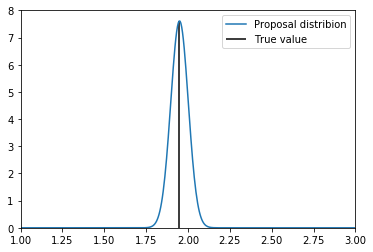

In [7]:
x = np.linspace(1,3,400)
y = norm.pdf(x,mu_val,np.exp(lg_sigma_val))

plt.plot(x,y,label="Proposal distribion")
plt.vlines(np.log(7),0,y.max(), label="True value")
plt.legend()

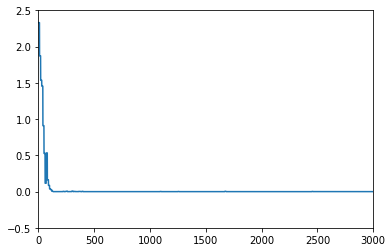

In [8]:
plt.plot(loss_d)

In [9]:
loss_d[::10]

[2.3307939,
 1.8725864,
 1.5357904,
 1.4544401,
 0.90902185,
 0.52622795,
 0.11472012,
 0.53316784,
 0.16267969,
 0.08478242,
 0.035881106,
 0.023668537,
 0.0042109923,
 -0.0009102336,
 -0.0009963096,
 -0.0009205475,
 2.8145849e-05,
 -0.00066064385,
 -0.001127073,
 -0.00054248224,
 -4.8098358e-05,
 -0.0006133113,
 0.0026521105,
 -0.00092268584,
 0.0012549682,
 0.005134163,
 -0.0010003198,
 -0.00084571046,
 -0.00085186807,
 -6.651377e-05,
 0.006535477,
 -0.00020993532,
 0.0017629823,
 -0.00017319332,
 -0.0009998975,
 -0.00045070593,
 0.0017473161,
 0.0011491213,
 -0.0010727317,
 0.0029125554,
 -0.0009900109,
 -0.0007367115,
 -0.000987435,
 -0.00074389717,
 -0.0005303099,
 -0.0009955419,
 -0.0008284172,
 -0.0009038066,
 -0.001002616,
 -0.0009956168,
 -0.0009939505,
 -0.0010182846,
 -0.0007945857,
 -0.0009985501,
 -0.00097342674,
 -0.0009994189,
 -0.0010022155,
 -0.00038020842,
 -0.00073375646,
 -0.0012984142,
 -0.0011875378,
 -0.0009907165,
 -0.0010000927,
 -0.0010410184,
 -0.0009993474,

In [10]:
np.savez("data.npz",loss_d=loss_d,em_v=em_v,mu_v=mu_v,sigma_v=sigma_v)